In [17]:
import pandas as pd
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup

ticker = 'BTC'
url = f'https://finviz.com/quote.ashx?t={ticker}'

req = Request(url=url, headers={'user-agent': 'my-app'})
response = urlopen(req)
html = BeautifulSoup(response, 'html.parser')

news_table = html.find(id='news-table')
news_rows = news_table.findAll('tr')

parsed_data = []
current_date = None  # To keep track of the date for multiple headlines on same day

for row in news_rows:
    a_tag = row.a
    if a_tag is not None:
        # 1. Clean the headline text from \r\n and whitespace
        title = a_tag.get_text().strip()
        
        # 2. Extract and fix the date/time
        date_td = row.td
        if date_td:
            date_text = date_td.text.strip()
            date_data = date_text.split(' ')
            
            if len(date_data) == 1:
                time = date_data[0]
            else:
                current_date = date_data[0] # Update current_date when a new date appears
                time = date_data[1]
                
            parsed_data.append([current_date, time, title])

# 3. Create DataFrame and convert to proper datetime objects
df = pd.DataFrame(parsed_data, columns=['date', 'time', 'headline'])

# Convert 'date' to datetime format for proper plotting
df['date'] = pd.to_datetime(df['date'], errors='coerce')

print("Cleaned Data")
print(df.head(10))

Cleaned Data
        date     time                                           headline
0 2025-12-22  06:35AM  How Bitcoin Could Help You Retire a Multimilli...
1 2025-12-21  10:41PM  Got $500? 3 Cryptocurrencies to Buy and Hold f...
2 2025-12-21  06:43PM  Shiba Inu vs. Bitcoin: The Better Long-Term Play?
3 2025-12-21  12:25PM            Can Iren Stock Beat the Market in 2026?
4 2025-12-21  11:27AM  1 Top Cryptocurrency to Buy Before It Soars 1,...
5 2025-12-21  06:50AM                 Better Crypto Buy: Bitcoin vs. XRP
6 2025-12-20  05:47PM  3 Reasons Why I'm Not Worried About Bitcoin Sl...
7 2025-12-20  01:31PM  Bitcoin vs. Dogecoin: What's the Better Long-T...
8 2025-12-20  01:20PM                  3 Best Bitcoin ETF Picks for 2026
9 2025-12-20  08:05AM  Michael Burry Compares Bitcoin to One of the B...


C:\Users\rahil\AppData\Local\Temp\ipykernel_104696\3703303523.py:42: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['date'], errors='coerce')


In [22]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

vader = SentimentIntensityAnalyzer()

# Apply sentiment analysis to each headline
df['sentiment_score'] = df['headline'].apply(lambda x: vader.polarity_scores(x)['compound'])

# Classify the sentiment
df['sentiment'] = df['sentiment_score'].apply(lambda score: 'Positive' if score > 0.05 else ('Negative' if score < -0.05 else 'Neutral'))

print(df[['headline', 'sentiment_score', 'sentiment']].head(10))

                                            headline  sentiment_score  \
0  How Bitcoin Could Help You Retire a Multimilli...           0.4019   
1  Got $500? 3 Cryptocurrencies to Buy and Hold f...           0.0000   
2  Shiba Inu vs. Bitcoin: The Better Long-Term Play?           0.6486   
3            Can Iren Stock Beat the Market in 2026?           0.0000   
4  1 Top Cryptocurrency to Buy Before It Soars 1,...           0.2023   
5                 Better Crypto Buy: Bitcoin vs. XRP           0.4404   
6  3 Reasons Why I'm Not Worried About Bitcoin Sl...           0.2235   
7  Bitcoin vs. Dogecoin: What's the Better Long-T...           0.6486   
8                  3 Best Bitcoin ETF Picks for 2026           0.6369   
9  Michael Burry Compares Bitcoin to One of the B...           0.0000   

  sentiment  
0  Positive  
1   Neutral  
2  Positive  
3   Neutral  
4  Positive  
5  Positive  
6  Positive  
7  Positive  
8  Positive  
9   Neutral  


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\rahil\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


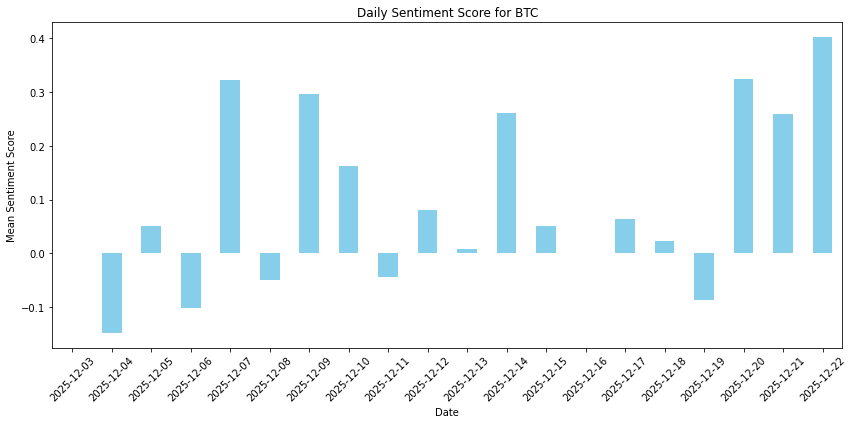

In [24]:
# Convert index to a cleaner string format for the bar chart
mean_df.index = mean_df.index.strftime('%Y-%m-%d')

plt.figure(figsize=(12, 6))
mean_df.plot(kind='bar', color='skyblue')
plt.title(f'Daily Sentiment Score for {ticker}')
plt.xlabel('Date')
plt.ylabel('Mean Sentiment Score')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()